## Import Dependencies

In [26]:
%pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from matplotlib.colors import LinearSegmentedColormap

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Data Preparation

### Load Datasets

In [27]:
# Load both datasets first
movies_df = pd.read_excel('/Users/fabicampanari/Desktop/Movies Recommensations/Movie companies.xlsx')



# Check the column names to understand the structure
print("Movies DataFrame columns:")
print(movies_df.columns.tolist())
print("\nRatings DataFrame columns:")


# Check the first few rows to understand the data
print("\nMovies DataFrame head:")
print(movies_df.head())
print("\nRatings DataFrame head:")


Movies DataFrame columns:
['Brand', 'Total', 'Releases', '#1 Release', 'Lifetime Gross']

Ratings DataFrame columns:

Movies DataFrame head:
                Brand        Total  Releases  \
0       Marvel Comics  15806336901        69   
1  Legendary Pictures   7018798067        56   
2           Lucasfilm   6325022918        39   
3               Pixar   6078217662        28   
4           DC Comics   5815645953        46   

                                   #1 Release  Lifetime Gross  
0                           Avengers: Endgame       858373000  
1                              Jurassic World       652270625  
2  Star Wars: Episode VII - The Force Awakens       936662225  
3                               Incredibles 2       608581744  
4                             The Dark Knight       533345358  

Ratings DataFrame head:


### Merge Data

## Data Preprocessing

### Feature Engineering

In [28]:
# Example: load ratings_df (update the path and format as needed)
# ratings_df = pd.read_excel('/path/to/ratings.xlsx')
# For demonstration, let's create a dummy ratings_df for illustration
# Replace this with your actual ratings_df loading code
ratings_df = pd.DataFrame({
	'userId': [1, 2, 1],
	'movieId': [101, 102, 103],
	'rating': [4.5, 3.0, 5.0],
	'title': ['Avengers: Endgame', 'Jurassic World', 'Star Wars: Episode VII - The Force Awakens']
})

# Merge ratings_df and movies_df to create 'data'
# Replace 'title' and '#1 Release' with actual column names if needed
data = pd.merge(ratings_df, movies_df, left_on='title', right_on='#1 Release', how='inner')

# if the movie belongs to any collection or not
data['is_in_collection'] = data['belongs_to_collection'].notnull() if 'belongs_to_collection' in data.columns else False

# filtering out movies that were not released (only if 'status' column exists)
if 'status' in data.columns:
	data = data[data['status'] == 'Released']

# extracting year from the release date of the movie (only if 'release_date' column exists)
if 'release_date' in data.columns:
	data['release_year'] = pd.to_datetime(data['release_date']).dt.year

# drop irrelevant columns from the data
data = data.drop(['adult', 'belongs_to_collection', 'homepage', 'id', 'original_title', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'tagline', 'video'], axis=1, errors='ignore')

### Data Preprocessing

In [29]:
# Only process genres if the column exists
if 'genres' in data.columns:
	# fill NULL values in Genres
	data['genres'] = data['genres'].fillna('[]')
	data['genres'] = data['genres'].apply(ast.literal_eval)    # string --> dictionaries

	# extract names from dictionaries
	data['genre_names'] = data['genres'].apply(lambda x: [d['name'] for d in x])

	# One-hot Encoding
	genres = data['genre_names'].str.join('|').str.get_dummies()
	no_of_genres = genres.sum().sort_values(ascending=False)

	data = pd.concat([data, genres], axis=1)
	data = data.drop(['genres', 'genre_names'], axis=1)
else:
	print("Column 'genres' not found in data. Skipping genre processing.")

Column 'genres' not found in data. Skipping genre processing.


## Data Visualization

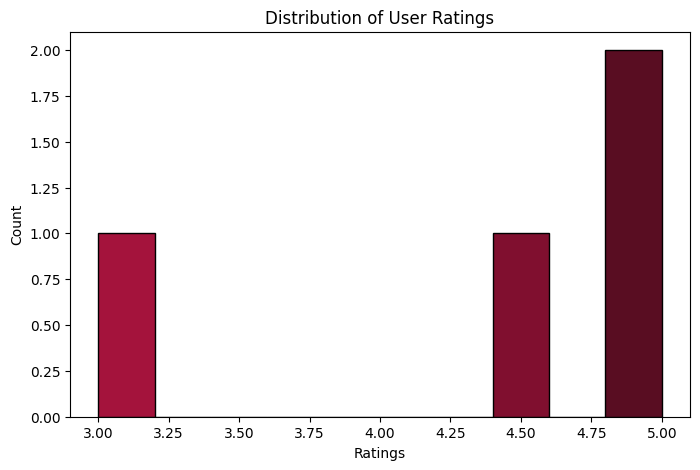

In [30]:
color_palette = ['#FFF0F3', '#FFCCD5', '#FFB3C1', '#FF8FA3', '#FF758F', '#FF4D6D', '#C9184A', '#A4133C', '#800F2F', '#590D22']
cmap_reds = LinearSegmentedColormap.from_list('custom_cmap', color_palette)

plt.figure(figsize=(8,5))
ax = sns.histplot(data['rating'], bins=10, kde=False)
heights = np.array([patch.get_height() for patch in ax.patches])
sorted_indices = np.argsort(heights)
for i, patch in enumerate(ax.patches):
    color_index = sorted_indices.tolist().index(i)
    patch.set_facecolor(color_palette[color_index % len(color_palette)])
plt.title('Distribution of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.savefig('../results/visualizations/ratings_dist.png', dpi=200)
plt.show()

Available columns in data:
['userId', 'movieId', 'rating', 'title', 'Brand', 'Total', 'Releases', '#1 Release', 'Lifetime Gross', 'is_in_collection']

Data types:
userId                int64
movieId               int64
rating              float64
title                object
Brand                object
Total                 int64
Releases              int64
#1 Release           object
Lifetime Gross        int64
is_in_collection       bool
dtype: object
Using numerical features: ['rating', 'Total', 'Releases', 'Lifetime Gross']


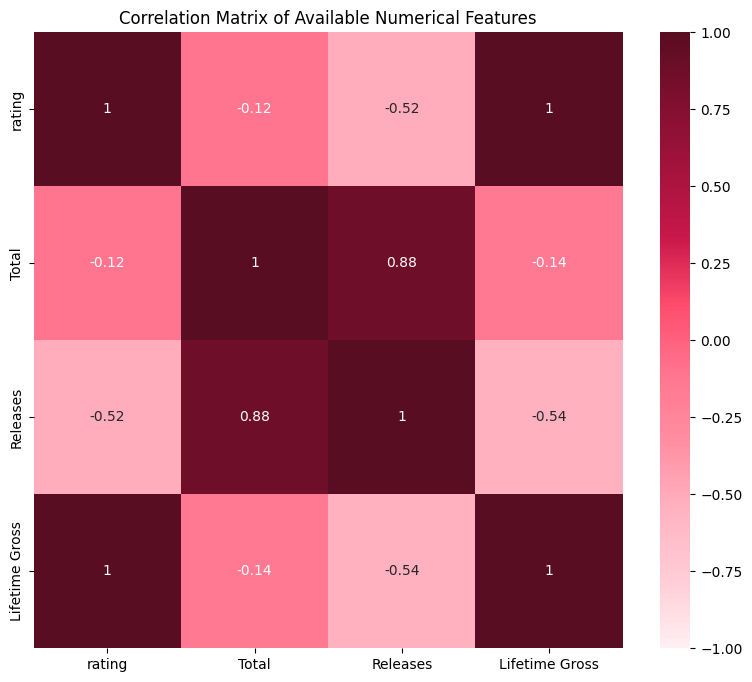

In [31]:
color_palette = ['#FFF0F3', '#FFCCD5', '#FFB3C1', '#FF8FA3', '#FF758F', '#FF4D6D', '#C9184A', '#A4133C', '#800F2F', '#590D22']
cmap_reds = LinearSegmentedColormap.from_list('custom_cmap', color_palette)

print("Available columns in data:")
print(data.columns.tolist())
print("\nData types:")
print(data.dtypes)

potential_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
existing_numerical_features = []
for feature in potential_features:
    if feature in data.columns:
        if data[feature].dtype in ['int64', 'float64', 'int32', 'float32']:
            existing_numerical_features.append(feature)

if not existing_numerical_features:
    numerical_cols = data.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
    existing_numerical_features = [col for col in numerical_cols if col not in ['userId', 'movieId']]

print(f"Using numerical features: {existing_numerical_features}")

if len(existing_numerical_features) >= 2:
    corr_matrix = data[existing_numerical_features].corr()
    plt.figure(figsize=(9.5,8))
    sns.heatmap(corr_matrix, annot=True, cmap=cmap_reds, vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Available Numerical Features')
    import os
    os.makedirs('../results/visualizations/', exist_ok=True)
    plt.savefig('../results/visualizations/heatmap_features.png', dpi=125)
    plt.show()
elif len(existing_numerical_features) == 1:
    print(f"Only one numerical feature found: {existing_numerical_features[0]}. Cannot create correlation matrix.")
else:
    print("No suitable numerical features found for correlation analysis.")
    print("Consider adding more numerical data or using a different visualization.")


## Data Preparation 2

### Embedding or Scaling Data

In [32]:
data['movieId'] = data['movieId'].astype('int')

data['userId'] = data['userId'].astype('int')

data['rating'] = data['rating']/5.0

### Train-Test Split

In [33]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [34]:
# 'userId' and 'movieId' will be features and 'rating' will be target for model

train_movieId = train['movieId'].values
test_movieId = test['movieId'].values

train_userId = train['userId'].values
test_userId = test['userId'].values

train_rating = train['rating'].values
test_rating = test['rating'].values

max_movieId = data['movieId'].max() + 1
max_userId = data['userId'].max() + 1

## Model Training

### Embedding

In [35]:
movie_inputs = layers.Input(shape=(1,), dtype=tf.int32, name='movie_input')
movie_embed = layers.Embedding(input_dim=max_movieId, output_dim=50)(movie_inputs)
movie_embed = layers.Flatten()(movie_embed)

user_inputs = layers.Input(shape=(1,), dtype=tf.int32, name='user_input')
user_embed = layers.Embedding(input_dim=max_userId, output_dim=50)(user_inputs)
user_embed = layers.Flatten()(user_embed)

user_movie_concat = layers.Concatenate()([user_embed, movie_embed])

In [36]:
train_userId = np.array(train_userId).reshape(-1, 1)
train_movieId = np.array(train_movieId).reshape(-1, 1)
test_userId = np.array(test_userId).reshape(-1, 1)
test_movieId = np.array(test_movieId).reshape(-1, 1)

print(train_userId.shape, train_movieId.shape, train_rating.shape)
print(test_userId.shape, test_movieId.shape, test_rating.shape)

(3, 1) (3, 1) (3,)
(1, 1) (1, 1) (1,)


### Build Model

In [37]:
dense = layers.Dense(256, activation='relu')(user_movie_concat)
dense = layers.BatchNormalization()(dense)
dense = layers.Dropout(0.2)(dense)
dense = layers.Dense(128, activation='relu')(dense)
dense = layers.Dense(64, activation='relu')(dense)
output = layers.Dense(1)(dense)

model = models.Model(inputs=[user_inputs, movie_inputs], outputs=output)
optimzer = Adam(learning_rate=0.001)

model.compile(optimizer=optimzer, loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 50)     │        150 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │      5,200 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     25,856 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,447 (286.90 KB)

 Trainable params: 72,935 (284.90 KB)

 Non-trainable params: 512 (2.00 KB)

In [38]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [39]:
history = model.fit(
    [train_userId, train_movieId],
    train_rating,
    epochs=10,                          
    batch_size=32,                     
    validation_data=([test_userId, test_movieId], test_rating),
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

model_mse = model.evaluate([test_userId, test_movieId], test_rating)
print(f'Model\'s Mean Squared Error: {model_mse}')

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step - loss: 1.0303 - val_loss: 0.9792 - learning_rate: 0.0010
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5193 - val_loss: 0.9518 - learning_rate: 0.0010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2705 - val_loss: 0.9261 - learning_rate: 0.0010
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0625 - val_loss: 0.9007 - learning_rate: 0.0010
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 9.6038e-04 - val_loss: 0.8794 - learning_rate: 0.0010
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0680 - val_loss: 0.8599 - learning_rate: 0.0010
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0598 - val_loss: 0.8510 - learning_rate: 0.0010
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0373 - val_loss: 0.8463 - learning_rate: 0.0010
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0398 - val_loss: 0.8459 - learning_rate: 0.0010
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━

## Movie Recommendation Generator

In [40]:
user_id = 1

all_movies = data['movieId'].unique()
rated_movies = data[data['userId']==user_id][['movieId', 'title', 'rating']]
unrated_movies = np.setdiff1d(all_movies, rated_movies['movieId'])

unrated_movies_inp = np.array(unrated_movies)
user_input_list = np.full(len(unrated_movies_inp), user_id)

In [41]:
ratings_prediction = model.predict([user_input_list, unrated_movies_inp])

movies_prediction = pd.DataFrame({
    'movieId': unrated_movies_inp,
    'rating_prediction': ratings_prediction.flatten()
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [42]:
recommendations = movies_prediction.sort_values(by='rating_prediction', ascending=False).head(15)
# Merge with 'data' to get the movie titles
recommendations = pd.merge(recommendations, data[['movieId', 'title']], on='movieId', how='left')
recommendations['rating_prediction'] = (recommendations['rating_prediction']*10).round(1)

print(f'Top Movie Recommendations for User {user_id}:')
print(recommendations[['title', 'rating_prediction']])

Top Movie Recommendations for User 1:
            title  rating_prediction
0  Jurassic World                0.5
